In [ ]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

# ---- PARÁMETROS DEL FILTRO ----
fs = 1000  # Frecuencia de muestreo (Hz)
lowcut = 20  # Frecuencia de corte del filtro pasa altas (Hz)
highcut = 500  # Frecuencia de corte del filtro pasa bajas (Hz)
order = 4  # Orden del filtro

# ---- FUNCIÓN PARA FILTROS ----
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def aplicar_filtro_bandpass(signal_data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, signal_data)  # Filtrado sin desfase
    return y

df = pd.read_csv('volunteer_1.csv')

emg_signal = df['HandOpen'].values
emg_signal2 = df['HandClose'].values


emg_filtrada = aplicar_filtro_bandpass(emg_signal, lowcut, highcut, fs, order)
emg_filtrada2 = aplicar_filtro_bandpass(emg_signal2, lowcut, highcut, fs, order)


# ---- GRAFICAR RESULTADOS ----
plt.figure(figsize=(12, 6))
plt.plot(emg_signal, label='Señal EMG Original', alpha=0.5)
plt.plot(emg_filtrada, label='Señal EMG Filtrada', color='red')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Señal EMG antes y después del filtrado')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(emg_signal2, label='Señal EMG Original 2', alpha=0.5)
plt.plot(emg_filtrada2, label='Señal EMG Filtrada 2', color='red')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Señal EMG antes y después del filtrado')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('volunteer_1.csv')
df.head

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

def load_emg_data(filepath):
    df = pd.read_csv(filepath)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def preprocess_data(df, signal_column='HandOpen', fs=1000):
    signal_data = df[signal_column].values.astype(float)  # Asegurar tipo float
    time = np.arange(len(signal_data)) / fs
    return time, signal_data

def apply_bandpass_filter(data, fs, lowcut=20, highcut=500, order=4):
    """Filtro paso banda corregido"""
    nyq = 0.5 * fs
    low = max(0.01, lowcut / nyq)  # Evitar 0 exacto
    high = min(0.99, highcut / nyq)  # Evitar 1 exacto
    
    if low >= high:
        raise ValueError(f"Frecuencias inválidas: lowcut={lowcut}Hz, highcut={highcut}Hz. Deben ser lowcut < highcut")
    
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def apply_notch_filter(data, fs, notch_freq=50, quality_factor=30):
    """Filtro notch para eliminar interferencia"""
    if notch_freq <= 0 or notch_freq >= fs/2:
        print(f"Frecuencia notch {notch_freq}Hz está fuera de rango. No se aplicará filtro notch.")
        return data.copy()
    
    b, a = signal.iirnotch(notch_freq, quality_factor, fs)
    return signal.filtfilt(b, a, data)

def moving_average_filter(data, window_size=100):
    """Filtro de media móvil mejorado"""
    if window_size < 1:
        return data.copy()
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def remove_outliers(data, threshold=3):
    """Eliminación de valores atípicos robusta"""
    if len(data) == 0:
        return data
    
    median = np.nanmedian(data)
    mad = 1.4826 * np.nanmedian(np.abs(data - median))  # Desviación absoluta mediana
    
    if mad == 0:  # Evitar división por cero
        return data
    
    z_scores = np.abs((data - median) / mad)
    outliers = z_scores > threshold
    data[outliers] = np.nan
    return data

def interpolate_missing(data, method='linear'):
    """Interpolación de datos faltantes mejorada"""
    mask = ~np.isnan(data)
    if np.sum(mask) < 2:  # Necesitamos al menos 2 puntos para interpolar
        return np.zeros_like(data)
    
    x = np.arange(len(data))
    return np.interp(x, x[mask], data[mask])

def full_emg_pipeline(df, signal_column='HandOpen', fs=1000):
    """Pipeline completo de procesamiento EMG robusto"""
    try:
        # 1. Cargar y preparar datos
        time, raw_signal = preprocess_data(df, signal_column, fs)
        
        # 2. Eliminar outliers
        clean_signal = remove_outliers(raw_signal)
        
        # 3. Interpolar valores faltantes
        clean_signal = interpolate_missing(clean_signal)
        
        # 4. Filtro paso banda (20-500Hz)
        filtered = apply_bandpass_filter(clean_signal, fs)
        
        # 5. Filtro notch (50Hz)
        filtered = apply_notch_filter(filtered, fs)
        
        # 6. Rectificación (valor absoluto)
        rectified = np.abs(filtered)
        
        # 7. Filtro de media móvil (suavizado)
        window_size = max(5, int(0.1 * fs))  # Ventana mínima de 5 muestras
        smoothed = moving_average_filter(rectified, window_size)
        
        # 8. Normalización [0-1] evitando división por cero
        min_val = np.min(smoothed)
        max_val = np.max(smoothed)
        if max_val != min_val:
            normalized = (smoothed - min_val) / (max_val - min_val)
        else:
            normalized = np.zeros_like(smoothed)
        
        return time, raw_signal, normalized
    
    except Exception as e:
        print(f"Error procesando {signal_column}: {str(e)}")
        time = np.arange(len(df)) / fs
        return time, np.zeros(len(df)), np.zeros(len(df))

def plot_results(time, raw, processed, title=''):
    """Visualización de resultados mejorada"""
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, raw, 'b', label='Señal cruda', alpha=0.7)
    plt.title(f'Señal EMG cruda - {title}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(time, processed, 'r', label='Señal procesada', alpha=0.7)
    plt.title(f'Señal EMG procesada - {title}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud normalizada')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_all_movements(df, fs=1000):
    """Analiza todas las columnas de movimiento del dataset de forma segura"""
    movement_columns = [col for col in df.columns if col not in ['Unnamed: 0', 'Rest'] and df[col].dtype in [np.float64, np.int64]]
    
    for movement in movement_columns:
        try:
            print(f"\nProcesando: {movement}")
            time, raw, processed = full_emg_pipeline(df, movement, fs)
            plot_results(time, raw, processed, title=movement)
        except Exception as e:
            print(f"Error al procesar {movement}: {str(e)}")

if __name__ == "__main__":
    # Configuración
    filepath = 'volunteer_1.csv'  # Cambiar por tu ruta real
    sampling_rate = 1000  # Ajustar según tu dataset
    
    try:
        # 1. Cargar datos
        print("Cargando datos EMG...")
        emg_df = load_emg_data(filepath)
        
        # Verificar datos cargados
        print("\nColumnas disponibles:", emg_df.columns.tolist())
        print("Muestra de datos:")
        print(emg_df.head())
        
        # 2. Procesar y visualizar todas las señales de movimiento
        print("\nProcesando todas las señales de movimiento...")
        analyze_all_movements(emg_df, sampling_rate)
        
        # 3. Ejemplo de procesamiento para una señal específica
        print("\nEjemplo detallado para HandOpen:")
        time, raw, processed = full_emg_pipeline(emg_df, 'HandOpen', sampling_rate)
        
        # Visualización detallada
        plt.figure(figsize=(12, 8))
        
        # Señal cruda
        plt.subplot(3, 1, 1)
        plt.plot(time, raw, 'b')
        plt.title('Señal EMG Cruda (HandOpen)')
        plt.ylabel('Amplitud')
        plt.grid(True)
        
        # Señal después de filtros (sin rectificar)
        _, filtered, _ = full_emg_pipeline(emg_df, 'HandOpen', sampling_rate)
        plt.subplot(3, 1, 2)
        plt.plot(time, filtered, 'g')
        plt.title('Después de Filtros (Paso Banda + Notch)')
        plt.ylabel('Amplitud')
        plt.grid(True)
        
        # Señal procesada final
        plt.subplot(3, 1, 3)
        plt.plot(time, processed, 'r')
        plt.title('Señal Procesada Final (Rectificada y Suavizada)')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud normalizada')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error general: {str(e)}")

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import tf2zpk, freqz, zpk2tf

def load_emg_data(filepath):
    """Carga datos EMG desde un archivo CSV"""
    df = pd.read_csv(filepath)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def preprocess_data(df, signal_column='HandOpen', fs=1000):
    """Preprocesamiento básico de los datos"""
    signal_data = df[signal_column].values.astype(float)
    time = np.arange(len(signal_data)) / fs
    return time, signal_data

def apply_z_transform_filter(data, fs, lowcut=None, highcut=None, order=4):
    """
    Aplica un filtro digital usando la Transformada Z con validación de frecuencias
    
    Args:
        data: Señal de entrada
        fs: Frecuencia de muestreo
        lowcut: Frecuencia de corte inferior (para pasa banda/altos)
        highcut: Frecuencia de corte superior (para pasa banda/bajos)
        order: Orden del filtro
    """
    nyq = 0.5 * fs
    
    # Validación y normalización de frecuencias
    if highcut is not None:
        highcut_norm = highcut / nyq
        if highcut_norm >= 1.0:
            highcut_norm = 0.99  # Ajustar para evitar error
    else:
        highcut_norm = None
        
    if lowcut is not None:
        lowcut_norm = lowcut / nyq
        if lowcut_norm <= 0:
            lowcut_norm = 0.01  # Ajustar para evitar error
    else:
        lowcut_norm = None
    
    # Determinar tipo de filtro
    if lowcut is not None and highcut is not None:
        if lowcut >= highcut:
            raise ValueError("La frecuencia de corte inferior debe ser menor que la superior")
        b, a = signal.butter(order, [lowcut_norm, highcut_norm], btype='band')
    elif highcut is not None:
        b, a = signal.butter(order, highcut_norm, btype='low')
    elif lowcut is not None:
        b, a = signal.butter(order, lowcut_norm, btype='high')
    else:
        return data.copy(), ([], [], 1)  # Sin filtro
    
    # Aplicar filtro
    filtered = signal.filtfilt(b, a, data)
    z, p, k = tf2zpk(b, a)
    
    return filtered, (z, p, k)

def plot_z_plane(z, p, title='Diagrama de Polos y Ceros'):
    """Visualiza el diagrama de polos y ceros"""
    plt.figure(figsize=(8, 6))
    
    # Dibujar círculo unitario
    unit_circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.3)
    plt.gca().add_patch(unit_circle)
    
    # Dibujar polos y ceros
    plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='b', label='Ceros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Polos')
    
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

def moving_average_filter(data, window_size=100):
    """Filtro de media móvil mejorado"""
    if window_size < 1:
        return data.copy()
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def analyze_signal_with_z_transform(df, signal_column, fs=1000):
    """Análisis completo de una señal con Transformada Z"""
    try:
        # 1. Cargar y preparar datos
        time, raw_signal = preprocess_data(df, signal_column, fs)
        
        # 2. Aplicar filtro pasa banda (20-500Hz) con Transformada Z
        filtered, (z, p, k) = apply_z_transform_filter(raw_signal, fs, lowcut=20, highcut=500)
        
        # 3. Visualizar diagrama de polos y ceros
        plot_z_plane(z, p, title=f'Filtro {signal_column}')
        
        # 4. Calcular respuesta en frecuencia
        w, h = freqz(*zpk2tf(z, p, k))
        plt.figure()
        plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
        plt.title(f'Respuesta en Frecuencia - {signal_column}')
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('Amplitud [dB]')
        plt.grid()
        plt.show()
        
        # 5. Rectificación y suavizado
        rectified = np.abs(filtered)
        smoothed = moving_average_filter(rectified, window_size=100)
        
        # 6. Normalización
        normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))
        
        return time, raw_signal, filtered, normalized, (z, p, k)
    
    except Exception as e:
        print(f"Error procesando {signal_column}: {str(e)}")
        time = np.arange(len(df)) / fs
        return time, np.zeros(len(df)), np.zeros(len(df)), np.zeros(len(df)), ([], [], 0)

def extended_signal_analysis(df, signal_columns, fs=1000):
    """Análisis detallado para múltiples señales"""
    results = {}
    
    for signal_name in signal_columns:
        print(f"\n=== Análisis detallado para {signal_name} ===")
        
        # Procesamiento con Transformada Z
        time, raw, filtered, normalized, zpk = analyze_signal_with_z_transform(df, signal_name, fs)
        
        # Visualización comparativa
        plt.figure(figsize=(12, 8))
        
        plt.subplot(3, 1, 1)
        plt.plot(time, raw, 'b', alpha=0.7)
        plt.title(f'Señal Cruda - {signal_name}')
        plt.ylabel('Amplitud')
        plt.grid(True)
        
        plt.subplot(3, 1, 2)
        plt.plot(time, filtered, 'g', alpha=0.7)
        plt.title(f'Señal Filtrada (Transformada Z) - {signal_name}')
        plt.ylabel('Amplitud')
        plt.grid(True)
        
        plt.subplot(3, 1, 3)
        plt.plot(time, normalized, 'r', alpha=0.7)
        plt.title(f'Señal Procesada Final - {signal_name}')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud Normalizada')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Almacenar resultados
        results[signal_name] = {
            'time': time,
            'raw': raw,
            'filtered': filtered,
            'normalized': normalized,
            'zeros': zpk[0],
            'poles': zpk[1],
            'gain': zpk[2]
        }
    
    return results
if __name__ == "__main__":
    # Configuración
    filepath = 'volunteer_1.csv'
    sampling_rate = 1000
    
    try:
        # 1. Cargar datos
        print("Cargando datos EMG...")
        emg_df = load_emg_data(filepath)
        
        # 2. Identificar columnas de señales
        movement_columns = [col for col in emg_df.columns if col not in ['Unnamed: 0', 'Rest'] 
                          and emg_df[col].dtype in [np.float64, np.int64]]
        
        print("\nColumnas disponibles para análisis:", movement_columns)
        
        # 3. Análisis detallado para todas las señales
        results = extended_signal_analysis(emg_df, movement_columns, sampling_rate)
        
        # 4. Análisis comparativo entre señales
        plt.figure(figsize=(12, 6))
        for signal_name, data in results.items():
            plt.plot(data['time'], data['normalized'], label=signal_name, alpha=0.7)
        
        plt.title('Comparación de Señales EMG Procesadas')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud Normalizada')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Error general: {str(e)}")

Cargando datos EMG...

Columnas disponibles: ['HandOpen', 'HandClose', 'Wrist Flexion', 'Wrist Extension', 'Supination', 'Pronation', 'Rest']
Muestra de datos:
     HandOpen   HandClose  Wrist Flexion  Wrist Extension  Supination  \
0  581.622678  562.072336     395.894428         4.887586  107.526882   
1  615.835777  850.439883     723.362659         4.887586   43.988270   
2  503.421310  972.629521     938.416422         4.887586   24.437928   
3  317.693060  869.990225     967.741935        34.213099    4.887586   
4  131.964809  610.948192     821.114370       361.681329    4.887586   

   Pronation        Rest  
0  97.751711    4.887586  
1  39.100684   24.437928  
2  19.550342  161.290323  
3  14.662757  298.142717  
4   4.887586  371.456500  

Procesando señal: HandOpen


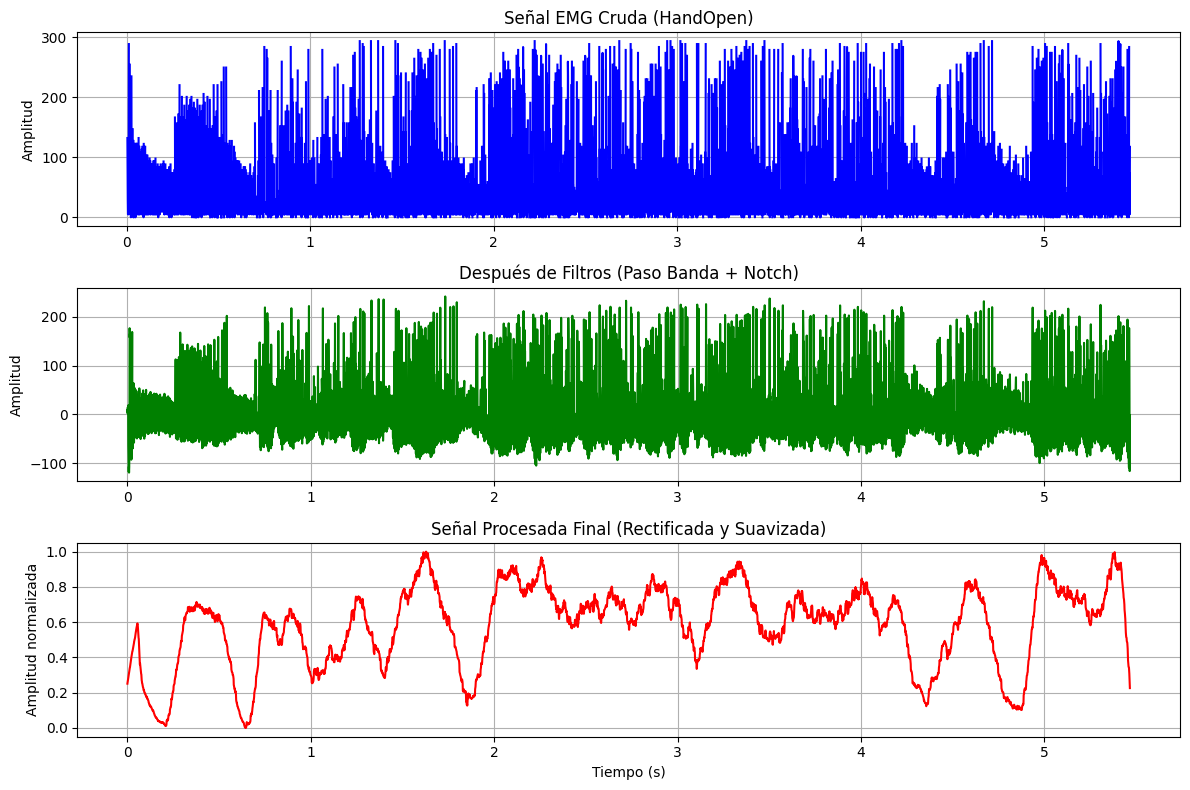

Estadísticas para HandOpen:
  - Raw signal: max=nan, min=nan, mean=nan
  - Processed: max=1.00, min=0.00, mean=0.59

Procesando señal: HandClose


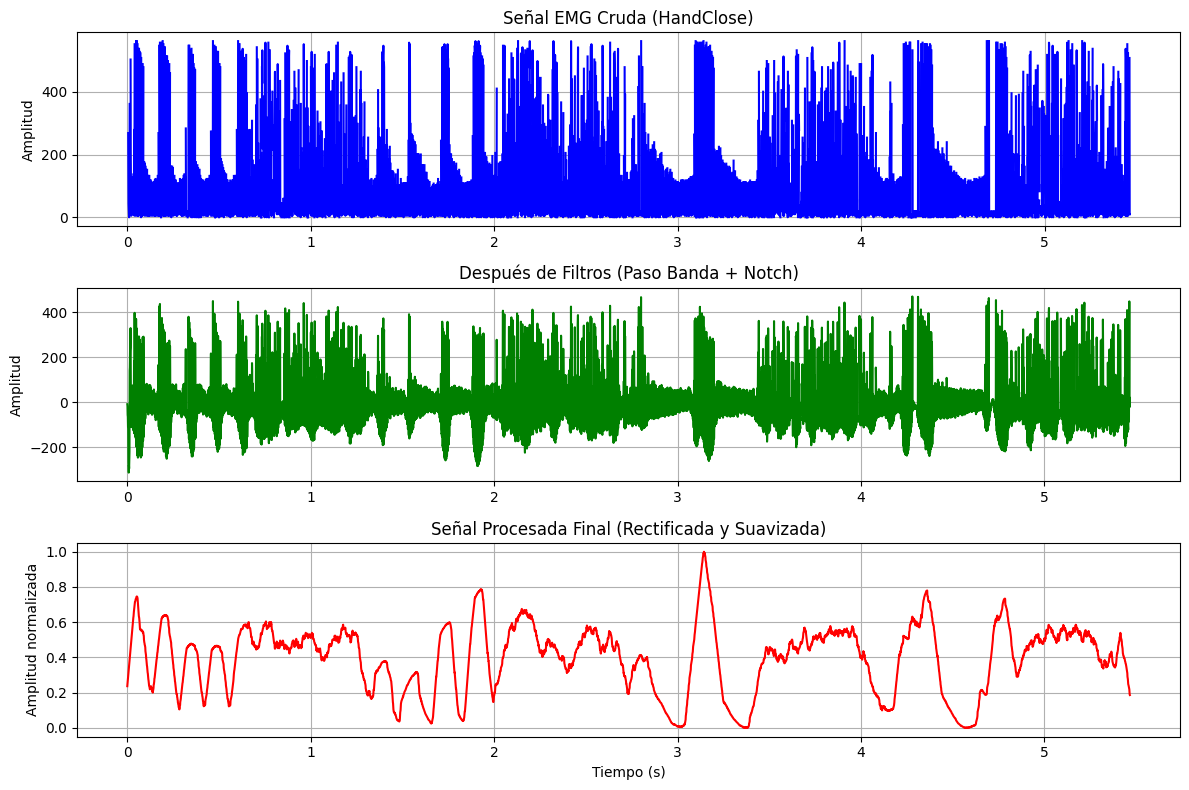

Estadísticas para HandClose:
  - Raw signal: max=nan, min=nan, mean=nan
  - Processed: max=1.00, min=0.00, mean=0.40

Procesando señal: Wrist Flexion


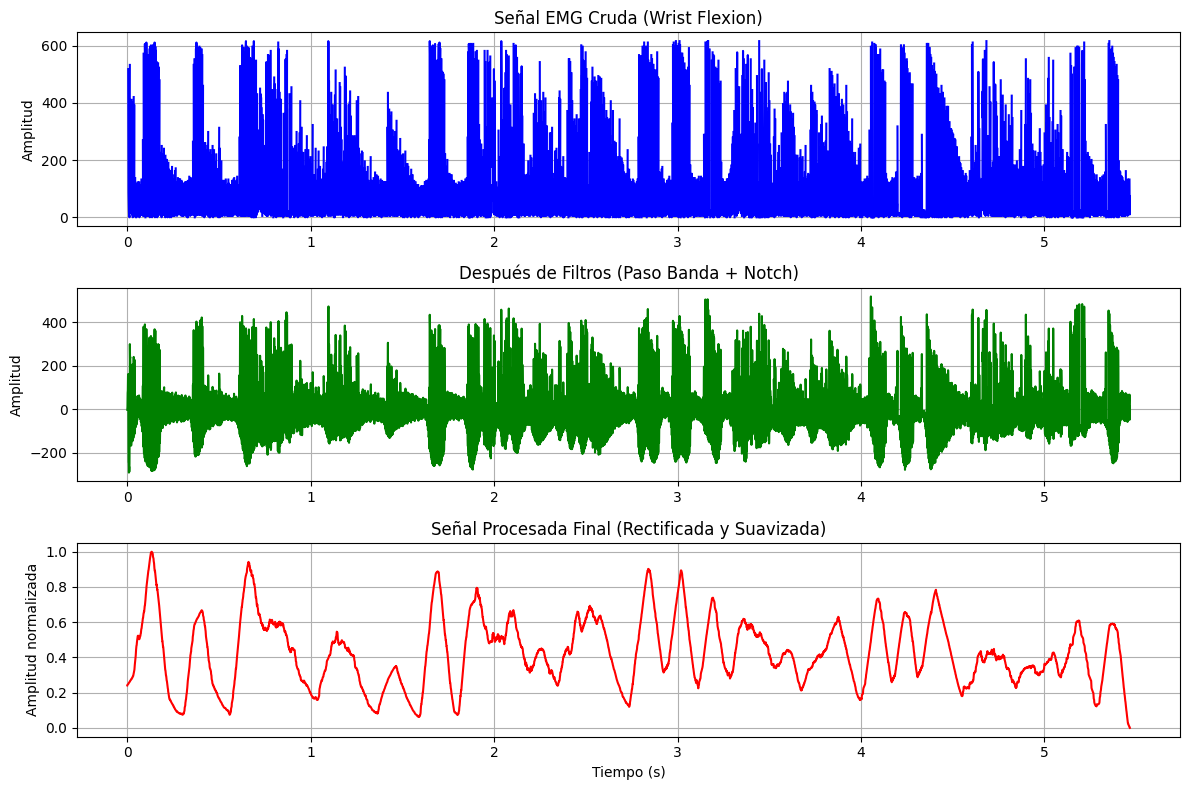

Estadísticas para Wrist Flexion:
  - Raw signal: max=nan, min=nan, mean=nan
  - Processed: max=1.00, min=0.00, mean=0.43

Procesando señal: Wrist Extension


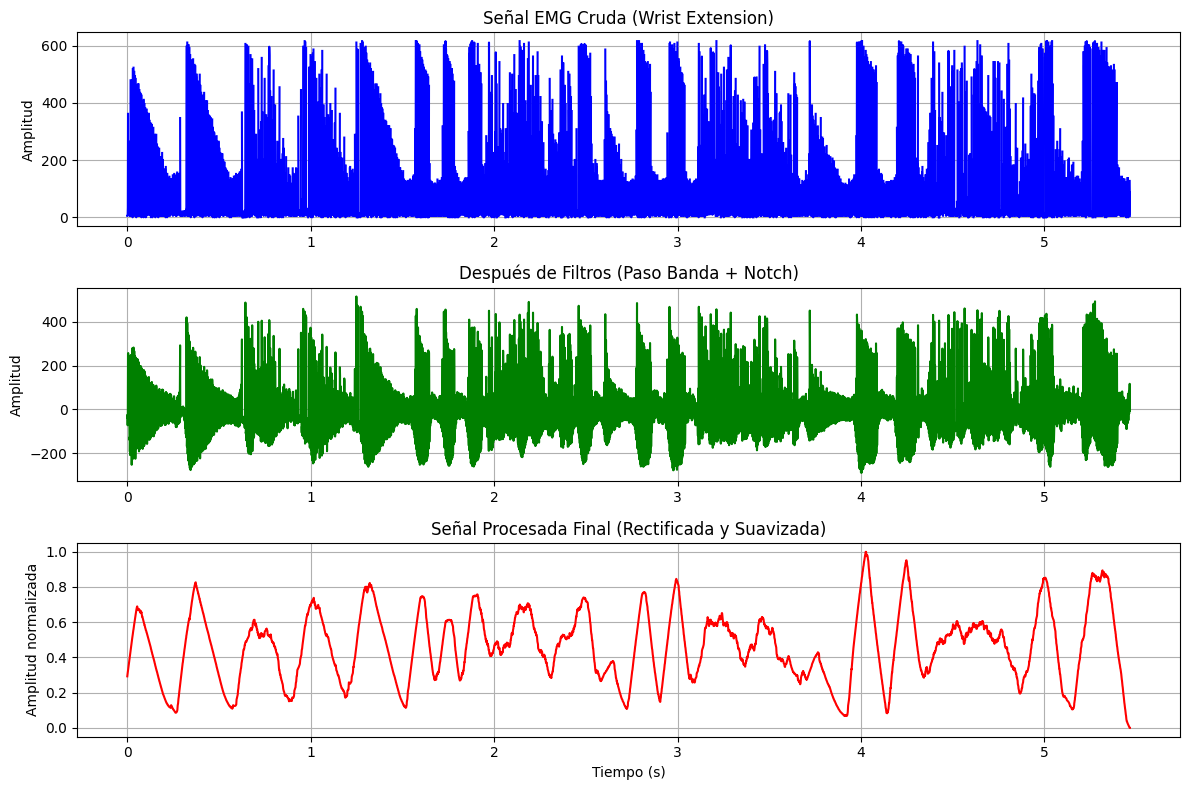

Estadísticas para Wrist Extension:
  - Raw signal: max=nan, min=nan, mean=nan
  - Processed: max=1.00, min=0.00, mean=0.47

Procesando señal: Supination


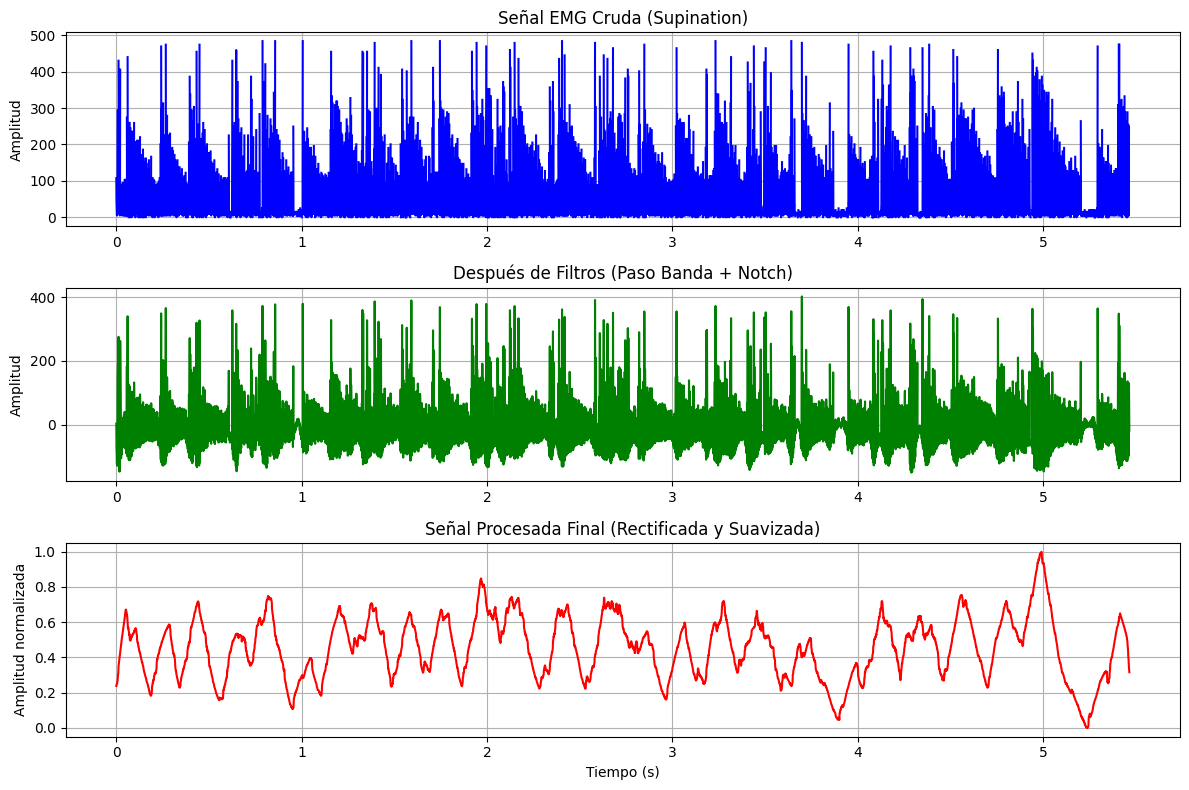

Estadísticas para Supination:
  - Raw signal: max=nan, min=nan, mean=nan
  - Processed: max=1.00, min=0.00, mean=0.46

Procesando señal: Pronation


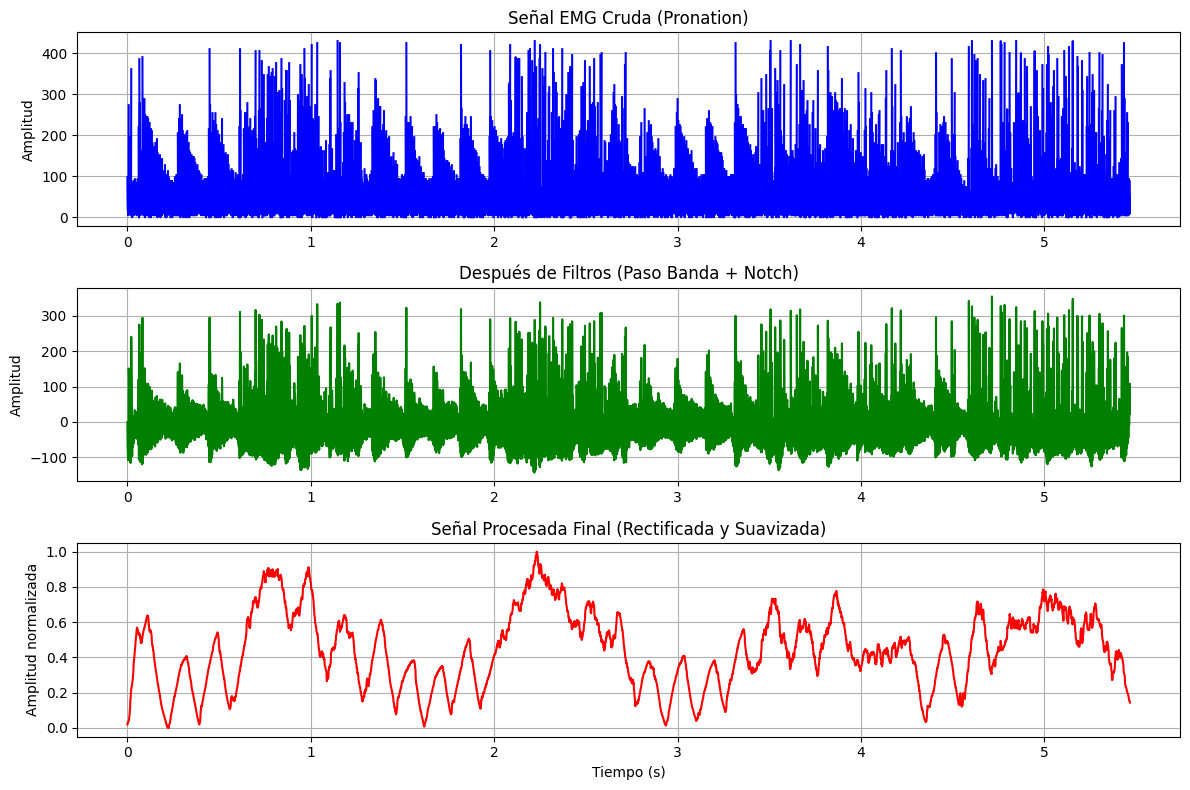

Estadísticas para Pronation:
  - Raw signal: max=nan, min=nan, mean=nan
  - Processed: max=1.00, min=0.00, mean=0.45


In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

def load_emg_data(filepath):
    df = pd.read_csv(filepath)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def preprocess_data(df, signal_column='HandOpen', fs=1000):
    signal_data = df[signal_column].values.astype(float)  # Asegurar tipo float
    time = np.arange(len(signal_data)) / fs
    return time, signal_data

def apply_bandpass_filter(data, fs, lowcut=20, highcut=500, order=4):
    """Filtro paso banda corregido"""
    nyq = 0.5 * fs
    low = max(0.01, lowcut / nyq)  # Evitar 0 exacto
    high = min(0.99, highcut / nyq)  # Evitar 1 exacto
    
    if low >= high:
        raise ValueError(f"Frecuencias inválidas: lowcut={lowcut}Hz, highcut={highcut}Hz. Deben ser lowcut < highcut")
    
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def apply_notch_filter(data, fs, notch_freq=50, quality_factor=30):
    """Filtro notch para eliminar interferencia"""
    if notch_freq <= 0 or notch_freq >= fs/2:
        print(f"Frecuencia notch {notch_freq}Hz está fuera de rango. No se aplicará filtro notch.")
        return data.copy()
    
    b, a = signal.iirnotch(notch_freq, quality_factor, fs)
    return signal.filtfilt(b, a, data)

def moving_average_filter(data, window_size=100):
    """Filtro de media móvil mejorado"""
    if window_size < 1:
        return data.copy()
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def remove_outliers(data, threshold=3):
    """Eliminación de valores atípicos robusta"""
    if len(data) == 0:
        return data
    
    median = np.nanmedian(data)
    mad = 1.4826 * np.nanmedian(np.abs(data - median))  # Desviación absoluta mediana
    
    if mad == 0:  # Evitar división por cero
        return data
    
    z_scores = np.abs((data - median) / mad)
    outliers = z_scores > threshold
    data[outliers] = np.nan
    return data

def interpolate_missing(data, method='linear'):
    """Interpolación de datos faltantes mejorada"""
    mask = ~np.isnan(data)
    if np.sum(mask) < 2:  # Necesitamos al menos 2 puntos para interpolar
        return np.zeros_like(data)
    
    x = np.arange(len(data))
    return np.interp(x, x[mask], data[mask])

def full_emg_pipeline(df, signal_column='HandOpen', fs=1000):
    """Pipeline completo de procesamiento EMG robusto"""
    try:
        # 1. Cargar y preparar datos
        time, raw_signal = preprocess_data(df, signal_column, fs)
        
        # 2. Eliminar outliers
        clean_signal = remove_outliers(raw_signal)
        
        # 3. Interpolar valores faltantes
        clean_signal = interpolate_missing(clean_signal)
        
        # 4. Filtro paso banda (20-500Hz)
        filtered = apply_bandpass_filter(clean_signal, fs)
        
        # 5. Filtro notch (50Hz)
        filtered = apply_notch_filter(filtered, fs)
        
        # 6. Rectificación (valor absoluto)
        rectified = np.abs(filtered)
        
        # 7. Filtro de media móvil (suavizado)
        window_size = max(5, int(0.1 * fs))  # Ventana mínima de 5 muestras
        smoothed = moving_average_filter(rectified, window_size)
        
        # 8. Normalización [0-1] evitando división por cero
        min_val = np.min(smoothed)
        max_val = np.max(smoothed)
        if max_val != min_val:
            normalized = (smoothed - min_val) / (max_val - min_val)
        else:
            normalized = np.zeros_like(smoothed)
        
        return time, raw_signal, normalized
    
    except Exception as e:
        print(f"Error procesando {signal_column}: {str(e)}")
        time = np.arange(len(df)) / fs
        return time, np.zeros(len(df)), np.zeros(len(df))

def plot_results(time, raw, processed, title=''):
    """Visualización de resultados mejorada"""
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, raw, 'b', label='Señal cruda', alpha=0.7)
    plt.title(f'Señal EMG cruda - {title}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(time, processed, 'r', label='Señal procesada', alpha=0.7)
    plt.title(f'Señal EMG procesada - {title}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud normalizada')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_all_movements(df, fs=1000):
    """Analiza todas las columnas de movimiento del dataset de forma segura"""
    movement_columns = [col for col in df.columns if col not in ['Unnamed: 0', 'Rest'] and df[col].dtype in [np.float64, np.int64]]
    
    for movement in movement_columns:
        try:
            print(f"\nProcesando: {movement}")
            time, raw, processed = full_emg_pipeline(df, movement, fs)
            plot_results(time, raw, processed, title=movement)
        except Exception as e:
            print(f"Error al procesar {movement}: {str(e)}")

if __name__ == "__main__":
    # Configuración
    filepath = 'volunteer_1.csv'  
    sampling_rate = 1000  
    
    try:
        # 1. Cargar datos
        print("Cargando datos EMG...")
        emg_df = load_emg_data(filepath)
        
        # Verificar datos cargados
        print("\nColumnas disponibles:", emg_df.columns.tolist())
        print("Muestra de datos:")
        print(emg_df.head())
        
        # 2. Identificar todas las columnas de movimiento
        movement_columns = [col for col in emg_df.columns 
                          if col not in ['Unnamed: 0', 'Rest'] 
                          and emg_df[col].dtype in [np.float64, np.int64]]
        
        # 3. Procesar y visualizar cada señal de movimiento individualmente
        for movement in movement_columns:
            print(f"\nProcesando señal: {movement}")
            
            # Procesamiento completo de la señal
            time, raw, processed = full_emg_pipeline(emg_df, movement, sampling_rate)
            
            # Visualización detallada para cada movimiento
            plt.figure(figsize=(12, 8))
            
            # Señal cruda
            plt.subplot(3, 1, 1)
            plt.plot(time, raw, 'b')
            plt.title(f'Señal EMG Cruda ({movement})')
            plt.ylabel('Amplitud')
            plt.grid(True)
            
            # Señal después de filtros (sin rectificar)
            try:
                # Proceso intermedio solo para obtener la señal filtrada
                time, raw_signal = preprocess_data(emg_df, movement, sampling_rate)
                clean_signal = remove_outliers(raw_signal)
                clean_signal = interpolate_missing(clean_signal)
                filtered = apply_bandpass_filter(clean_signal, sampling_rate)
                filtered = apply_notch_filter(filtered, sampling_rate)
                
                plt.subplot(3, 1, 2)
                plt.plot(time, filtered, 'g')
                plt.title('Después de Filtros (Paso Banda + Notch)')
                plt.ylabel('Amplitud')
                plt.grid(True)
            except Exception as e:
                print(f"Error al obtener señal filtrada para {movement}: {str(e)}")
                plt.subplot(3, 1, 2)
                plt.plot(time, np.zeros_like(time), 'g')
                plt.title('Error en filtrado')
                plt.grid(True)
            
            # Señal procesada final
            plt.subplot(3, 1, 3)
            plt.plot(time, processed, 'r')
            plt.title('Señal Procesada Final (Rectificada y Suavizada)')
            plt.xlabel('Tiempo (s)')
            plt.ylabel('Amplitud normalizada')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
            
            # Mostrar estadísticas básicas
            print(f"Estadísticas para {movement}:")
            print(f"  - Raw signal: max={np.max(raw):.2f}, min={np.min(raw):.2f}, mean={np.mean(raw):.2f}")
            print(f"  - Processed: max={np.max(processed):.2f}, min={np.min(processed):.2f}, mean={np.mean(processed):.2f}")
        
    except Exception as e:
        print(f"Error general: {str(e)}")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_emg_data(filepath):
    """Carga datos EMG desde un archivo CSV"""
    df = pd.read_csv(filepath)
    # Eliminar columnas de índice no deseadas
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def plot_raw_emg_signals(df, fs=1000):
    """
    Grafica todas las columnas numéricas del dataframe EMG
    
    Args:
        df: DataFrame con los datos EMG
        fs: Frecuencia de muestreo (opcional, para mostrar tiempo en segundos)
    """
    # Seleccionar solo columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) == 0:
        print("No se encontraron columnas numéricas para graficar")
        return
    
    print(f"\nColumnas a graficar: {list(numeric_cols)}")
    
    # Configurar tiempo (muestras o segundos)
    time = np.arange(len(df)) / fs if fs else np.arange(len(df))
    xlabel = 'Tiempo (s)' if fs else 'Muestras'
    
    # Crear figura con subplots
    fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 2.5*len(numeric_cols)))
    
    # Si solo hay una columna, convertir axes en lista
    if len(numeric_cols) == 1:
        axes = [axes]
    
    # Graficar cada columna
    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        ax.plot(time, df[col], color='blue', alpha=0.7)
        ax.set_title(f'Señal EMG - {col}', pad=10)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Amplitud')
        ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Configuración
    filepath = 'volunteer_filtered_1.csv'  # Reemplaza con tu archivo CSV
    sampling_rate = 1000  # Frecuencia de muestreo (Hz)
    
    try:
        # 1. Cargar datos
        print("Cargando datos EMG...")
        emg_df = load_emg_data(filepath)
        
        # 2. Mostrar información básica
        print("\nInformación del dataset:")
        print(emg_df.info())
        print("\nPrimeras 5 filas:")
        print(emg_df.head())
        
        # 3. Graficar todas las columnas numéricas
        print("\nGraficando señales EMG...")
        plot_raw_emg_signals(emg_df, fs=sampling_rate)
        
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {filepath}")
    except Exception as e:
        print(f"Error inesperado: {str(e)}")

Cargando datos EMG...
Error: No se encontró el archivo volunteer_filtered_1.csv
